In [1]:
!pip3 install asrtoolkit --user
!pip3 install fuzzywuzzy --user
!pip3 install python-Levenshtein --user
!pip3 install nltk

import asrtoolkit
from fuzzywuzzy import fuzz
import io
import os
from datetime import datetime
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from scipy import stats
from nltk.metrics import distance

  Using cached nltk-3.7-py3-none-any.whl (1.5 MB)


In [2]:
filenames = list(Path('predictions').glob('*.csv'))

results = pd.DataFrame()
# NUM_MODELS = len(filenames)
# header_model_names = [Path(f).stem.split('-')[0] for f in filenames]
# header_data_labels = ['ground_truth', 'prediction'] * NUM_MODELS
# results.columns = pd.MultiIndex.from_arrays([header_model_names, header_data_labels], names=('models', 'label'))

models = list()

for idx, filename in enumerate(filenames):
    new_results = pd.read_csv(filename)
    model_label = Path(filename).stem.split('-')[0]
    ground_truth_label = f'{model_label}-ground_truth'
    new_results = new_results.rename(columns={'label': ground_truth_label, 
                            'prediction': model_label})
    del new_results['Unnamed: 0']
    models.append((ground_truth_label, model_label))
    new_results[ground_truth_label] = new_results.apply(lambda r: str(r[ground_truth_label]), axis=1)
    new_results[model_label] = new_results.apply(lambda r: str(r[model_label]), axis=1)
    results = pd.concat([results, new_results], axis = 1)

results

,run_55_train-ground_truth,run_55_train,run_41_train-ground_truth,run_41_train,run_55_all-ground_truth,run_55_all,run_41_all-ground_truth,run_41_all
0,A,"""",A,"""""",A,A,A,A
1,more,more,more,more,more,more,more,more
2,a,a,a,a,a,a,a,a
3,Foot,Toot,Foot,Foot,Foot,Foot,Foot,Foot
4,and,and,and,and,and,and,and,and
...,...,...,...,...,...,...,...,...
10826,In,"""""",In,(,In,In,In,In
10827,beside,borde,beside,bssrde,beside,beside,beside,beside
10828,in,in,in,in,in,in,in,in
10829,',"""",',"""",',"""",',""""


In [3]:
models

[('run_55_train-ground_truth', 'run_55_train'),
 ('run_41_train-ground_truth', 'run_41_train'),
 ('run_55_all-ground_truth', 'run_55_all'),
 ('run_41_all-ground_truth', 'run_41_all')]

In [18]:
NUM_STATS = 4
NUM_SUB_STATS = 5
a = ['matchratio'] * NUM_SUB_STATS + ['CER'] * NUM_SUB_STATS + ['matchratio_insensitive'] * NUM_SUB_STATS + ['CER_insensitive'] * NUM_SUB_STATS
b = ['mean', 'min', 'max', 'stdev', 'median'] * NUM_STATS
headers = pd.MultiIndex.from_arrays([a,b], names=('stat', 'substats'))
summary_results = pd.DataFrame(columns=headers)
# summary_results.columns = headers


def match_ratio(query_label: str, model_label: str, summary_label: str):
    results[query_label] = subset.apply(lambda r: fuzz.ratio(str(r[ground_truth_label]), str(r[model_label])), axis=1)
    summary_results.loc[model_label, (summary_label, 'mean')] = results[query_label].mean()
    summary_results.loc[model_label, (summary_label, 'stdev')] = results[query_label].std(skipna=True)
    summary_results.loc[model_label, (summary_label, 'min')] = results[query_label].min(skipna=True)
    summary_results.loc[model_label, (summary_label, 'median')] = results[query_label].median(skipna=True)
    summary_results.loc[model_label, (summary_label, 'max')] = results[query_label].max(skipna=True)
    subset[query_label] = results[query_label]

def CER(query_label: str, model_label: str, summary_label: str):
    results[query_label] = subset.apply(lambda r: asrtoolkit.cer(str(r[ground_truth_label]), str(r[model_label])), axis=1)
    summary_results.loc[model_label, (summary_label, 'mean')] = results[query_label].mean(skipna=True)
    summary_results.loc[model_label, (summary_label, 'stdev')] = results[query_label].std(skipna=True)
    summary_results.loc[model_label, (summary_label, 'min')] = results[query_label].min(skipna=True)
    summary_results.loc[model_label, (summary_label, 'median')] = results[query_label].median(skipna=True)
    summary_results.loc[model_label, (summary_label, 'max')] = results[query_label].max(skipna=True)
    subset[query_label] = results[query_label]
    

for ground_truth_label, model_label in models:
    subset = results[[ground_truth_label, model_label]].dropna()
    CER(f'{model_label} CER', model_label, 'CER')
    match_ratio(f'{model_label} match ratio', model_label, 'matchratio')
    
    subset[ground_truth_label] = subset[ground_truth_label].map(str.lower)
    subset[model_label] = subset[model_label].map(str.lower)
    CER(f'{model_label} CER_insensitive', model_label, 'CER_insensitive')
    match_ratio(f'{model_label} match ratio insensitive', model_label, 'matchratio_insensitive')

    exact = subset.apply(lambda r: 1 if str(r[ground_truth_label]) == str(r[model_label]) else 0, axis=1).sum()
    oboe = subset.apply(lambda r: 1 if int((len(r[ground_truth_label]) + len(r[model_label])) - \
                                            r[f'{model_label} match ratio'] / 100 * \
                                            (len(r[ground_truth_label]) + len(r[model_label]))) == 1 else 0, axis=1).sum()
    
    results[f'{model_label}-edit_distance'] = subset.apply(lambda r: distance.edit_distance(str(r[ground_truth_label]), str(r[model_label])), axis=1)
    exact2 = results.apply(lambda r: 1 if int(r[f'{model_label}-edit_distance']) == 0 else 0, axis=1).sum()
    oboe2 = results.apply(lambda r: 1 if int(r[f'{model_label}-edit_distance']) == 1 else 0, axis=1).sum()
    summary_results.loc[model_label, 'exact_matches'] = pd.to_numeric(exact, downcast='integer')
    summary_results.loc[model_label, 'oboe_matches'] = pd.to_numeric(oboe, downcast='integer')
    summary_results.loc[model_label, 'oboe_matches2'] = pd.to_numeric(oboe2, downcast='integer')
    summary_results.loc[model_label, 'exact_matches2'] = pd.to_numeric(exact2, downcast='integer')
        
    ci=0.95
    err_range = stats.norm.interval(alpha=ci, 
                                  loc=np.mean(results[f'{model_label} CER'].dropna()), 
                                  scale=stats.sem(results[f'{model_label} CER'].dropna()))
    summary_results.loc[model_label, 'cer_95_error_min'] = err_range[0]
    summary_results.loc[model_label, 'cer_95_error_max'] = err_range[1]

summary_results

stat         matchratio                                   CER               \
substats           mean min  max      stdev median       mean  min     max   
run_55_train  82.751454   0  100    30.5051  100.0  14.060104  0.0  1000.0   
run_41_train  83.380944   0  100  30.052607  100.0  12.637878  0.0   900.0   
run_55_all    92.227495   0  100  24.512991  100.0   2.249663  0.0   600.0   
run_41_all     92.38953   0  100  24.396315  100.0   1.818202  0.0   300.0   

stat                            ... CER_insensitive                            \
substats          stdev median  ...             min     max      stdev median   
run_55_train   36.87105    0.0  ...             0.0  1000.0   36.98157    0.0   
run_41_train  32.078617    0.0  ...             0.0   900.0   32.13602    0.0   
run_55_all    14.601561    0.0  ...             0.0   600.0  14.594527    0.0   
run_41_all    12.186159    0.0  ...             0.0   300.0  12.171722    0.0   

stat         exact_matches oboe_matches oboe_matches2 exact_matches2  \
substats                                                               
run_55_train        7080.0        616.0        1975.0         7080.0   
run_41_train        7152.0        657.0        2055.0         7152.0   
run_55_all          9515.0        174.0         904.0         9515.0   
run_41_all          9605.0        160.0         854.0         9605.0   

stat         cer_95_error_min cer_95_error_max  
substats                                        
run_55_train        13.365721        14.754488  
run_41_train        12.033750        13.242007  
run_55_all           1.974676         2.524651  
run_41_all           1.588703         2.047701  

[4 rows x 26 columns]

In [25]:
summary_results.loc[models[0][1], ('CER', 'mean')]

14.060104121121947

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator


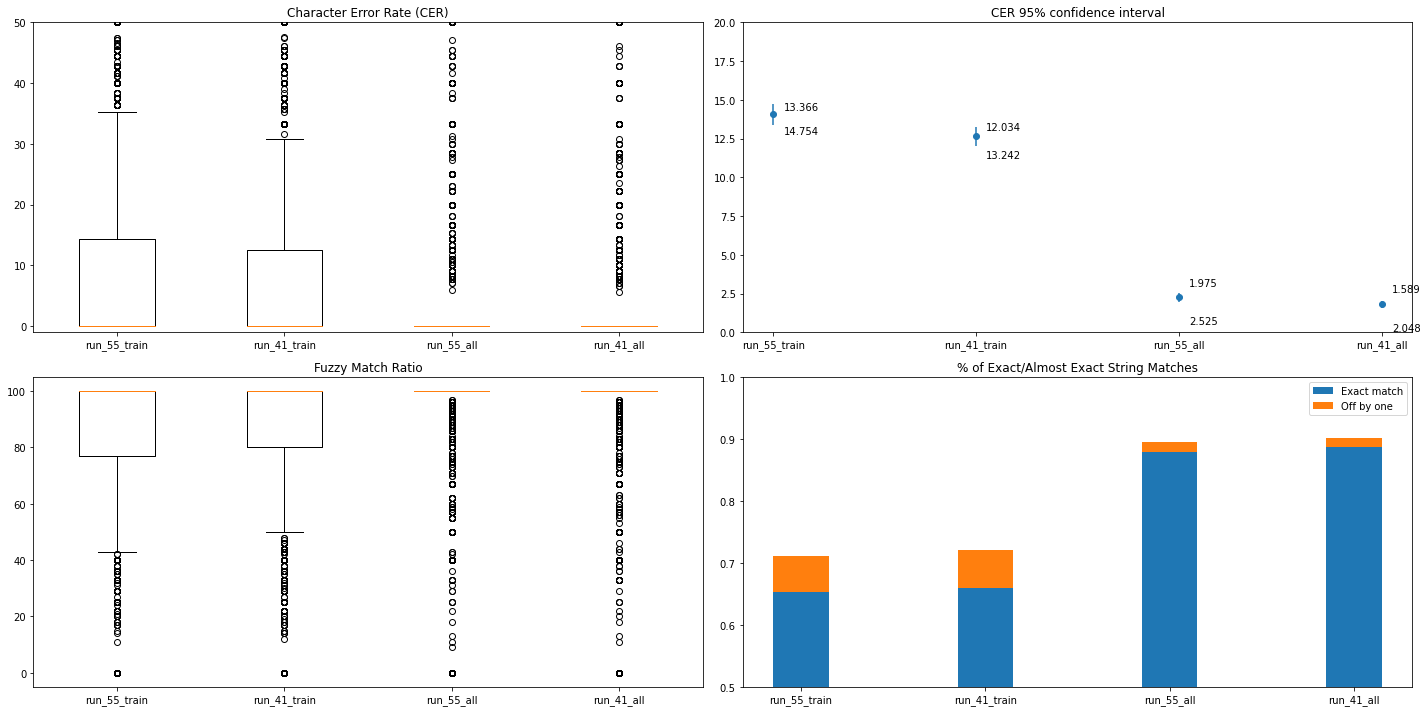

In [27]:
def plot_cer(graph):
    graph.set_title('Character Error Rate (CER)')
    graph.set_xticklabels([label[1] for label in models])
    graph.set_ylim([-1, 50])  # TODO -10, 400  ***********************************************************************************
    subset = results[[f'{label[1]} CER' for label in models]].T
    subset = np.asarray([model[1].dropna() for model in subset.iterrows()], dtype=object).T
    graph = graph.boxplot(subset)


def plot_cer_confidence_interval(graph):
    min = summary_results['cer_95_error_min']
    min = min.apply(lambda v: v if v >= 0 else 0)
    max = summary_results['cer_95_error_max']
    max = max.apply(lambda v: v if v <= 100 else 100)
    error_min = [summary_results.loc[label[1], ('CER', 'mean')] - min[label[1]] for label in models]
    error_max = [max[label[1]] - summary_results.loc[label[1], ('CER', 'mean')] for label in models]
    graph.set_title('CER 95% confidence interval')
    graph.set_xticklabels([label[1] for label in models])
    graph.set_ylim(top=20)  # TODO 100 ***********************************************************************************
    graph.errorbar([label[1] for label in models], summary_results[('CER', 'mean')], yerr=[error_min, error_max], fmt='o')
    for i in range(len(models)):
        graph.text(i + 0.05, max[i] - 2, f'{max[i]:.3f}')
        graph.text(i + 0.05, min[i] + 1, f'{min[i]:.3f}')


def plot_fuzzy_match(graph):
    graph.set_title('Fuzzy Match Ratio')
    graph.set_xticklabels([label[1] for label in models])
    subset = results[[f'{label[1]} match ratio' for label in models]].T
    subset = np.asarray([model[1].dropna() for model in subset.iterrows()], dtype=object).T
    graph = graph.boxplot(subset)


def plot_close_matches(graph):  # todo
    graph.set_title('% of Exact/Almost Exact String Matches')
    exact_matches = [match/results.shape[0] for match in summary_results['exact_matches']]
    obo_matches = [match/results.shape[0] for match in summary_results['oboe_matches']]
    ex = graph.bar([label[1] for label in models], exact_matches, 
                   width=0.3, label='Exact match')
    obo = graph.bar([label[1] for label in models], obo_matches, 
                    width=0.3, bottom=exact_matches, label='Off by one')
    height = int(summary_results['exact_matches'].max()) + int(summary_results['oboe_matches'].max()) + 5
    graph.set_ybound(0.5, 1)
    graph.legend()


fig, ((graph1, graph2), (graph3, graph4)) = plt.subplots(2, 2, figsize=(20, 10))
# fig, graph1 = plt.subplots(1, 1, figsize=(10, 7))  # For saving individual charts

plot_cer(graph1)
plot_cer_confidence_interval(graph2)
plot_fuzzy_match(graph3)
plot_close_matches(graph4)
fig.tight_layout()

# Save these results to the filesystem

In [28]:
results_folder = 'results'
if not os.path.exists(results_folder):
    os.makedirs(results_folder)
timestamp = datetime.now().strftime('%Y_%m_%d-%H_%M_%S')
summary_results.to_csv(Path(results_folder, f'summary-{timestamp}.csv'))
fig.savefig(Path(results_folder, f'summary-{timestamp}.png'))